# Data preparation

## Import base

In [1]:
import pandas as pd

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits.dtypes
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
movies.shape

(4803, 20)

In [8]:
credits.shape

(4803, 4)

In [9]:
# Let's just transform the release date to a datetime type
movies['release_date'] = pd.to_datetime(movies['release_date'])

## Merge credits and movie

In [10]:
data = credits.merge(movies, left_on='movie_id', right_on='id')

In [11]:
data

,movie_id,title_x,cast,crew,budget,genres,homepage,id,keywords,original_language,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,...,"[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,...,[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallm

In [12]:
data.drop(columns='id', inplace=True)

In [13]:
data.set_index('movie_id', inplace=True)

In [14]:
data

,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,...,"[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""

## Removing missing values

In [15]:
data.isna().sum()

title_x                    0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_y                    0
vote_average               0
vote_count                 0
dtype: int64

We see that almost all homepages are missing, and as they are not particularly useful, removing completely the column should do. As for the release date and the runtime, we should be able to substitute a reasonable value. The most difficult is going to be working with the missing taglines, but we might end up not using them. 

In [16]:
# Let's take care of the missing release date
data.drop(index=data[data['release_date'].isna()].index, inplace=True)
# This particular movies was too recently released, and everything is missing so we drop it
# It seems that we didn't take into account all the empty lists and null values 

In [17]:
chimameti = data[data['runtime'].isna()].index[0]
frank_sinatra = data[data['runtime'].isna()].index[1]
data.loc[chimameti, 'runtime'] = 113.0
data.loc[frank_sinatra, 'runtime'] = 81.0

We are going to differentiate in addition of the existing data types lists and strings. It's going to be important as the list have subattributes that can be extracted later, but also because the missing value manifests by an empty list which isn't considered NaN by pandas.

In [18]:
data.dtypes

title_x                         object
cast                            object
crew                            object
budget                           int64
genres                          object
homepage                        object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title_y                         object
vote_average                   float64
vote_count                       int64
dtype: object

In [19]:
# Let's split the database by column type so that we can search for missing values properly
(data.select_dtypes('number') == 0).sum()

budget          1036
popularity         0
revenue         1426
runtime           34
vote_average      62
vote_count        61
dtype: int64

In [20]:
# Here we split the columns between strings and json 
str_cols, json_cols = [], []
for column in data.select_dtypes('object'):
    if data[column].iloc[0][0] == '[':
        json_cols.append(column)
    else :
        str_cols.append(column)

In [21]:
for column in data[json_cols]:
    data[column] = data[column].map(eval)

In [22]:
(data[json_cols].applymap(len) == 0).sum()

cast                     42
crew                     27
genres                   27
keywords                411
production_companies    350
production_countries    173
spoken_languages         85
dtype: int64

In [23]:
data['cast'][285]

[{'cast_id': 4,
  'character': 'Captain Jack Sparrow',
  'credit_id': '52fe4232c3a36847f800b50d',
  'gender': 2,
  'id': 85,
  'name': 'Johnny Depp',
  'order': 0},
 {'cast_id': 5,
  'character': 'Will Turner',
  'credit_id': '52fe4232c3a36847f800b511',
  'gender': 2,
  'id': 114,
  'name': 'Orlando Bloom',
  'order': 1},
 {'cast_id': 6,
  'character': 'Elizabeth Swann',
  'credit_id': '52fe4232c3a36847f800b515',
  'gender': 1,
  'id': 116,
  'name': 'Keira Knightley',
  'order': 2},
 {'cast_id': 12,
  'character': 'William "Bootstrap Bill" Turner',
  'credit_id': '52fe4232c3a36847f800b52d',
  'gender': 2,
  'id': 1640,
  'name': 'Stellan Skarsgård',
  'order': 3},
 {'cast_id': 10,
  'character': 'Captain Sao Feng',
  'credit_id': '52fe4232c3a36847f800b525',
  'gender': 2,
  'id': 1619,
  'name': 'Chow Yun-fat',
  'order': 4},
 {'cast_id': 9,
  'character': 'Captain Davy Jones',
  'credit_id': '52fe4232c3a36847f800b521',
  'gender': 2,
  'id': 2440,
  'name': 'Bill Nighy',
  'order': 5

In [24]:
data[str_cols].isna().sum()

title_x                 0
homepage             3090
original_language       0
original_title          0
overview                3
status                  0
tagline               843
title_y                 0
dtype: int64

In [25]:
chimameti_desc = 'A biopic of the rise of father Jorge Mario Bergoglio SJ from a teacher in a Jesuit High School in Argentina to archbishop and cardinal of Buenos Aires to Pope of the Roman Catholic Church. The story touches on his relation with his fellow Jesuits in Argentina and Europe, to his relation with laureate writer Jorge Luis Borges, Argentine dictator Jorge Rafael Videla, and archbishops Laghi (nuncio to Argentina) and Quarracino (cardinal of Buenos Aires), up to the moment where he is elected Pope in 2013'
frank_sinatra_desc = 'The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon.'
food_chains_desc = 'There is so much interest in food these days yet there is almost no interest in the hands that pick that food. In the US, farm labor has always been one of the most difficult and poorly paid jobs and has relied on some of the nation\'s most vulnerable people. While the legal restrictions which kept people bound to farms, like slavery, have been abolished, exploitation still exists, ranging from wage theft to modern-day slavery. These days, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets. Their buying power has kept wages pitifully low and has created a scenario where desperately poor people are willing to put up with anything to keep their jobs.'

In [26]:
data[data['overview'].isna()]

,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
370980,Chiamatemi Francesco - Il Papa della gente,"[{'cast_id': 5, 'character': 'Jorge Mario Berg...","[{'credit_id': '5660019ac3a36875f100252b', 'de...",15000000,"[{'id': 18, 'name': 'Drama'}]",NaN,"[{'id': 717, 'name': 'pope'}, {'id': 5565, 'na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,...,"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2015-12-03,0,113.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
459488,"To Be Frank, Sinatra at 100","[{'cast_id': 0, 'character': 'Narrator', 'cred...","[{'credit_id': '592b25e4c3a368783e065a2f', 'de...",2,"[{'id': 99, 'name': 'Documentary'}]",NaN,"[{'id': 6027, 'name': 'music'}, {'id': 225822,...",en,"To Be Frank, Sinatra at 100",NaN,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2015-12-12,0,81.0,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0
292539,Food Chains,[],"[{'credit_id': '5470c3b1c3a368085e000abd', 'de...",913000,"[{'id': 99, 'name': 'Documentary'}]",NaN,[],de,Food Chains,NaN,...,[],2014-04-26,0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Food Chains,7.4,8


In [27]:
# Let's fill in manually the missing overviews
data.loc[chimameti, 'overview'] = chimameti_desc
data.loc[frank_sinatra, 'overview'] = frank_sinatra
data.loc[data['overview'].isna(), 'overview'] = food_chains_desc

In [28]:
data.drop(columns='homepage', inplace=True)

We delete the lines where cast or crew is missing because it would be much more work to recover these information and only a few are missing. 

In [29]:
data.drop(index=data[data['crew'].map(len) == 0].index, inplace=True)
data.drop(index=data[data['cast'].map(len) == 0].index, inplace=True)

Now we need to consider all the 'list' missing values. Those are more difficult to handle because they involve ids and conventions from the database. It's relatively easy to scrap imdb but less to match the info we can get there with the ones we already have. We will leave this part for when we have a specific id of our need in terms of missing values. 

# Initial analysis

In [30]:
import ast

In [31]:
import matplotlib.pyplot as plt

In [32]:
import datetime

In [33]:
import numpy as np

In [34]:
import seaborn as sns

In [35]:
#let's change the type of the column genre so we can manipulate it easily
data['listedgenre'] = data['genres'].fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else 
                                                                           [])

In [36]:
s = data.apply(lambda x: pd.Series(x['listedgenre']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

<ipython-input-36-65f5289b0519>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = data.apply(lambda x: pd.Series(x['listedgenre']),axis=1).stack().reset_index(level=1, drop=True)


In [37]:
gen_df = data.join(s)
data.head()

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]"
206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]"
49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]"
49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]"


In [38]:
# statistical description of the data base
data.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.753000e+03,4753.000000,4.753000e+03,4753.000000,4753.000000,4753.000000
mean,2.934747e+07,21.716692,8.311795e+07,107.338102,6.115548,697.453608
std,4.082845e+07,31.907864,1.634951e+08,21.840078,1.125401,1239.035703
min,0.000000e+00,0.000372,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+06,4.901936,0.000000e+00,94.000000,5.600000,57.000000
50%,1.500000e+07,13.237835,1.977765e+07,104.000000,6.200000,240.000000
75%,4.000000e+07,28.605420,9.400000e+07,118.000000,6.800000,749.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [39]:
data.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.502944,0.729985,0.266367,0.084750,0.591561
popularity,0.502944,1.000000,0.643566,0.220842,0.278880,0.777308
revenue,0.729985,0.643566,1.000000,0.250886,0.200148,0.780861
runtime,0.266367,0.220842,0.250886,1.000000,0.363044,0.271530
vote_average,0.084750,0.278880,0.200148,0.363044,1.000000,0.322849
vote_count,0.591561,0.777308,0.780861,0.271530,0.322849,1.000000


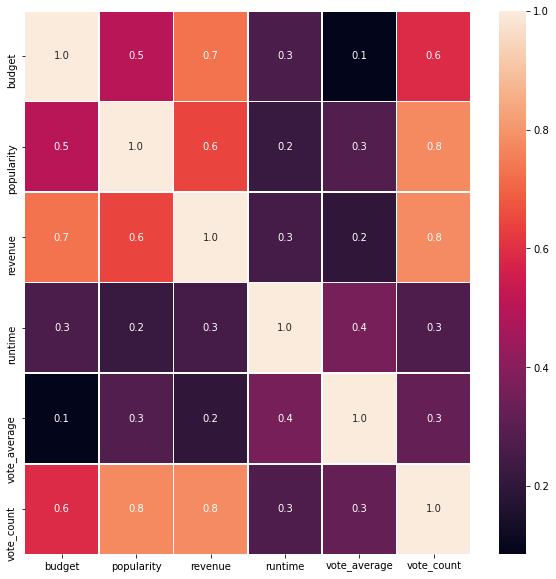

In [40]:
## Correlation map visualisation
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, fmt = '.1f', ax = ax)
plt.show()


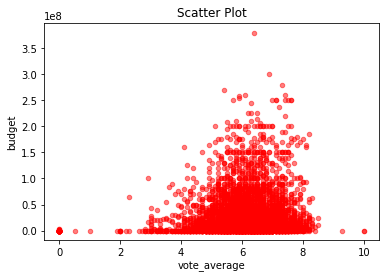

In [41]:
#showing the level of correlation between budget and vote_average using Scatter Plot
data.plot(kind='scatter', x='vote_average', y='budget', alpha=.5, color='r')
plt.xlabel('vote_average')
plt.ylabel('budget')
plt.title('Scatter Plot')
plt.show()

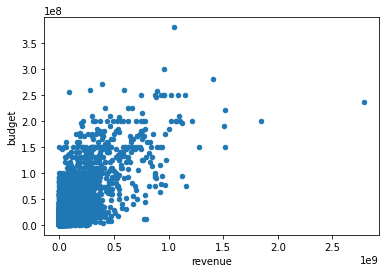

In [42]:
#showing the level of correlation between budget and revenue using Scatter Plot
data.plot(kind = 'scatter', x = 'revenue', y = 'budget')
plt.show()

In [43]:
# we will add a new column 'profit-rate' based on the relation between budget and revenue
data['profit_rate'] = data.revenue / data.budget
data.head()

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre,profit_rate
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",11.763566
285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",3.203333
206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",3.594590
49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",4.339756
49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",1.092843


Movie's Genre

In [44]:
from collections import Counter

In [70]:
genres = pd.DataFrame.from_dict(dict(Counter(data['listedgenre'].sum())),orient="index").reset_index()
genres.columns=['genre','movies']
genres.sort_values(by='movies',inplace=True, ascending=False)
genres

,genre,movies
5,Drama,2291
10,Comedy,1716
6,Thriller,1272
0,Action,1152
11,Romance,892
1,Adventure,790
4,Crime,695
3,Science Fiction,534
12,Horror,518
8,Family,508


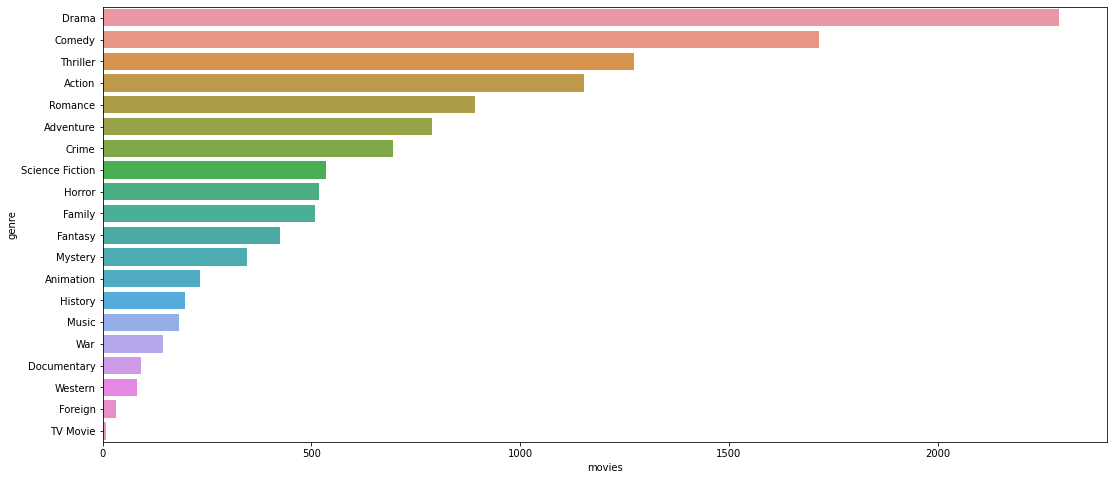

In [72]:
plt.figure(figsize=(18,8))
sns.barplot(x='movies', y='genre', data=genres)
plt.show()

To see the distribution of the genres in our Data Base, it seems to be helpfull not to work with the release_date which gives the exact date of release but rather consider the year of release so that we can group the films by year and see the distribution of the genres

In [73]:
# To have a better insight on the release_date
data['release_date'].head()

movie_id
19995    2009-12-10
285      2007-05-19
206647   2015-10-26
49026    2012-07-16
49529    2012-03-07
Name: release_date, dtype: datetime64[ns]

In [74]:
# Extrating the year of release
data['year'] = data['release_date'].dt.strftime('%Y')

In [75]:
data.head()

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre,profit_rate,year
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",11.763566,2009
285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",3.203333,2007
206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",3.594590,2015
49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",4.339756,2012
49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",1.092843,2012


Now that we have the column 'year', the visualisation is easier to code

In [76]:
# we can start by obtaining the range of years in the dataset
# minimum range value
min_year = data['year'].min()
# maximum range value
max_year = data['year'].max()
# print the range
print(min_year, max_year)

1916 2017


In [77]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [78]:
data[data['original_title'] != data['title_x']][['title_x', 'original_title']].head()

,title_x,original_title
movie_id,,
315011,Shin Godzilla,シン・ゴジラ
1979,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer
2395,Asterix at the Olympic Games,Astérix aux Jeux Olympiques
76758,The Flowers of War,金陵十三釵
330770,Evolution,Évolution


In [79]:
data[data['original_title'] != data['title_y']][['title_y', 'original_title']].head()

,title_y,original_title
movie_id,,
315011,Shin Godzilla,シン・ゴジラ
1979,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer
2395,Asterix at the Olympic Games,Astérix aux Jeux Olympiques
76758,The Flowers of War,金陵十三釵
330770,Evolution,Évolution


as we can see, title_y and title_x are the same and are the translation of original_title in English which we will consider in our wordcloud 

In [80]:
#converting the type of title and overview
data['title_x'] = data['title_x'].astype('str')
data['overview'] = data['overview'].astype('str')

In [81]:
title_corpus = ' '.join(data['title_x'])
overview_corpus = ' '.join(data['overview'])

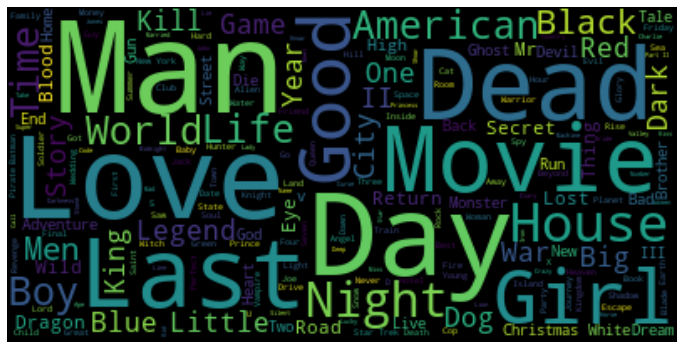

In [82]:
# Creating and generating a word cloud image based on the title:
wordcloud = WordCloud().generate(title_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

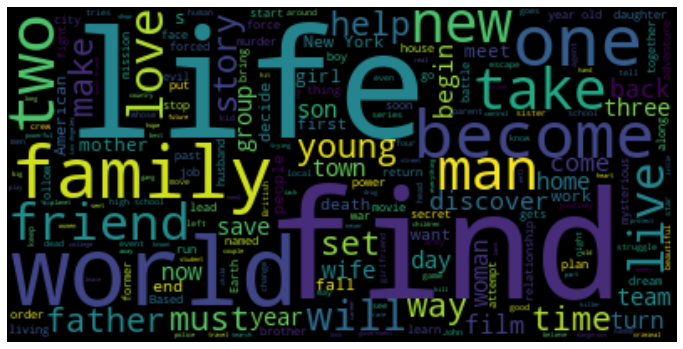

In [83]:
# Creating and generating a word cloud image based on the overview:
wordcloud = WordCloud().generate(overview_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Recommending by rating
TODO : paragraph about imdb ratings

We will start with a simple recommendation system which simply recommends the best movies in the database.

In [84]:
# Let's choose the minimum amount of ratings for us to consider the movie
# Here we only take into account movies that have more votes than 80% of the list
min_votes = data['vote_count'].quantile(0.8)
min_votes

966.0

In [85]:
v = data['vote_count']
m = min_votes
R = data['vote_average']
C = data['vote_average'].mean()

In [86]:
data['weighted_rating'] = (v / (v + m) * R) + (m / (v+m) * C)
data

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre,profit_rate,year,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",11.763566,2009,7.117940
285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",3.203333,2007,6.761365
206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",3.594590,2015,6.267198
49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",4.339756,2012,7.457627
49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",1.092843,2012,6.104861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,El Mariachi,"[{'cast_id': 1, 'character': 'El Mariachi', 'c...","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",220000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 5616, 'name': 'united states–mexico ba...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,...,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,"[Action, Crime, Thriller]",9.276909,1992,6.211312
72766,Newlyweds,"[{'cast_id': 1, 'character': 'Buzzy', 'credit_...","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",9000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,...,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,"[Comedy, Romance]",0.000000,2011,6.114438
231617,"Signed, Sealed, Delivered","[{'cast_id': 8, 'character': 'Oliver O’Toole',...","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 248, 'name': 'date'}, {'id': 699, 'nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delive

In [87]:
# The best movies of all time ...
data.sort_values('weighted_rating', ascending=False).head(10)

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre,profit_rate,year,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
278,The Shawshank Redemption,"[{'cast_id': 3, 'character': 'Andy Dufresne', ...","[{'credit_id': '52fe4231c3a36847f800b153', 'de...",25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'id': 378, 'name': 'prison'}, {'id': 417, 'n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,"[Drama, Crime]",1.133659,1994,8.248841
550,Fight Club,"[{'cast_id': 4, 'character': 'The Narrator', '...","[{'credit_id': '55731b8192514111610027d7', 'de...",63000000,"[{'id': 18, 'name': 'Drama'}]","[{'id': 825, 'name': 'support group'}, {'id': ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mischief. Mayhem. Soap.,Fight Club,8.3,9413,[Drama],1.600853,1999,8.096687
238,The Godfather,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093c9', 'de...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",143.659698,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,The Godfather,8.4,5893,"[Drama, Crime]",40.844402,1972,8.078265
680,Pulp Fiction,"[{'cast_id': 2, 'character': 'Vincent Vega', '...","[{'credit_id': '52fe4269c3a36847f801caa3', 'de...",8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...","[{'id': 396, 'name': 'transporter'}, {'id': 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,"[Thriller, Crime]",26.741095,1994,8.075369
155,The Dark Knight,"[{'cast_id': 35, 'character': 'Bruce Wayne', '...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,"[Drama, Action, Crime, Thriller]",5.430046,2008,8.044727
13,Forrest Gump,"[{'cast_id': 7, 'character': 'Forrest Gump', '...","[{'credit_id': '52fe420ec3a36847f800076b', 'de...",55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 422, 'name': 'vietnam veteran'}, {'id'...",en,Forrest Gump,A man with a low IQ has accomplished great thi...,138.133331,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,7927,"[Comedy, Drama, Romance]",12.326280,1994,7.973577
27205,Inception,"[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...","[{'credit_id': '56e8462cc3a368408400354c', 'de...",160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...","[{'id': 1014, 'name': 'loss of lover'}, {'id':...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Your mind is the scene of the crime.,Inception,8.1,13752,"[Action, Thriller, Science Fiction, Mystery, A...",5.159580,2010,7.969753
157336,Interstellar,"[{'cast_id': 9, 'character': 'Joseph Cooper', ...","[{'credit_id': '52fe4bbf9251416c910e4801', 'de...",165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","[{'id': 83, 'name': 'saving the world'}, {'id'...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mankind was bo

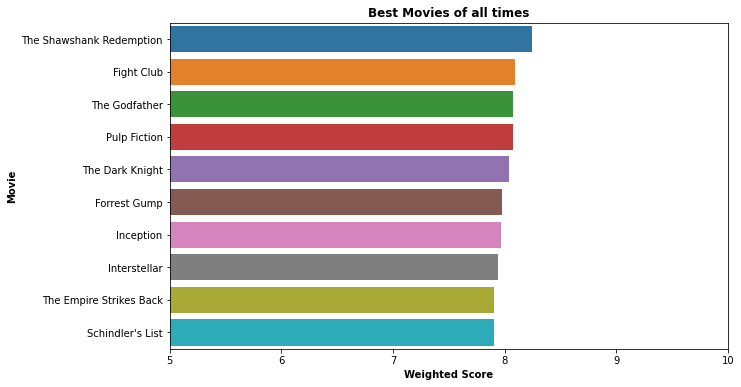

In [88]:
weight_average=data.sort_values('weighted_rating',ascending=False)
plt.figure(figsize=(10,6))
axis1=sns.barplot(x=weight_average['weighted_rating'].head(10), y=weight_average['original_title'].head(10), data=weight_average)
plt.xlim(5, 10)
plt.title('Best Movies of all times', weight='bold')
plt.xlabel('Weighted Score', weight='bold')
plt.ylabel('Movie', weight='bold');

In [89]:
# Which is not the same as if we sort by popularity
data.sort_values('popularity', ascending=False).head(10)

,title_x,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title_y,vote_average,vote_count,listedgenre,profit_rate,year,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
211672,Minions,"[{'cast_id': 22, 'character': 'Scarlet Overkil...","[{'credit_id': '5431b2b10e0a2656e20026c7', 'de...",74000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...","[{'id': 3487, 'name': 'assistant'}, {'id': 179...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Before Gru, they had a history of bad bosses",Minions,6.4,4571,"[Family, Animation, Adventure, Comedy]",15.631499,2015,6.350374
157336,Interstellar,"[{'cast_id': 9, 'character': 'Joseph Cooper', ...","[{'credit_id': '52fe4bbf9251416c910e4801', 'de...",165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...","[{'id': 83, 'name': 'saving the world'}, {'id'...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,10867,"[Adventure, Drama, Science Fiction]",4.091636,2014,7.937997
293660,Deadpool,"[{'cast_id': 99, 'character': 'Wade Wilson / D...","[{'credit_id': '56c986b2925141172f0068b6', 'de...",58000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 2095, 'name': 'anti hero'}, {'id': 307...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Witness the beginning of a happy ending,Deadpool,7.4,10995,"[Action, Adventure, Comedy]",13.501948,2016,7.296264
118340,Guardians of the Galaxy,"[{'cast_id': 1, 'character': 'Peter Quill / St...","[{'credit_id': '538ce329c3a3687155003358', 'de...",170000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...","[{'id': 8828, 'name': 'marvel comic'}, {'id': ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All heroes start somewhere.,Guardians of the Galaxy,7.9,9742,"[Action, Science Fiction, Adventure]",4.548992,2014,7.739019
76341,Mad Max: Fury Road,"[{'cast_id': 2, 'character': 'Max Rockatansky'...","[{'credit_id': '577da370c3a36817f8003838', 'de...",150000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 2964, 'name': 'future'}, {'id': 3713, ...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What a Lovely Day.,Mad Max: Fury Road,7.2,9427,"[Action, Adventure, Science Fiction, Thriller]",2.525722,2015,7.099203
135397,Jurassic World,"[{'cast_id': 10, 'character': 'Owen Grady', 'c...","[{'credit_id': '52fe4bf7c3a368484e1a0683', 'de...",150000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1299, 'name': 'monster'}, {'id': 1718,...",en,Jurassic World,Twenty-two years after the events of Jurassic ...,418.708552,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The park is open.,Jurassic World,6.5,8662,"[Action, Adventure, Science Fiction, Thriller]",10.090192,2015,6.461427
22,Pirates of the Caribbean: The Curse of the Bla...,"[{'cast_id': 12, 'character': 'Captain Jack Sp...","[{'credit_id': '52fe420fc3a36847f8000f11', 'de...",140000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 911, 'name': 'exotic island'}, {'id': ...",en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",271.972889,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,7.5,6985,"[Adventure, Fantasy, Action]",4.678652,2003,7.331797
119450,Dawn of the Planet of the Apes,"[{'cast_id': 8, 'character': 'Caesar', 'credit...","[{'credit_id': '54c4d125c3a36814210139a5', 'de...",170000000,"[{'id': 878, 'name': 'Science Ficti

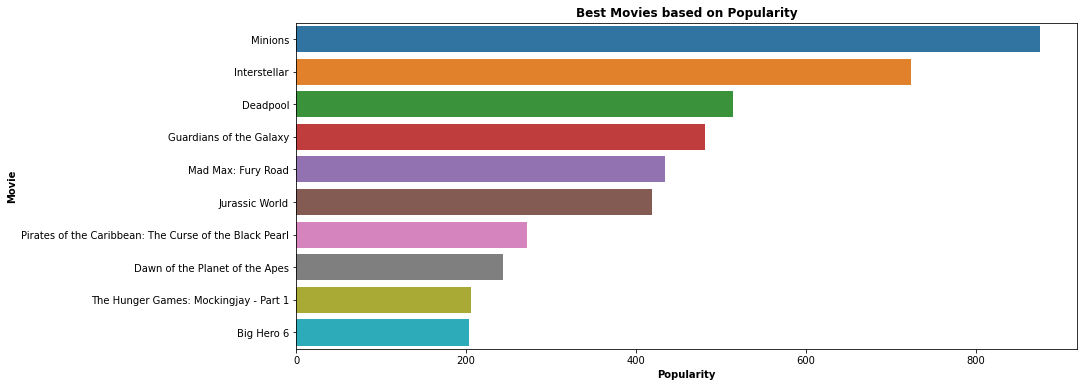

In [90]:
weight_popularity=data.sort_values('popularity',ascending=False)
plt.figure(figsize=(14,6))
axis1=sns.barplot(x=weight_popularity['popularity'].head(10), y=weight_popularity['original_title'].head(10), data=weight_popularity);
plt.title('Best Movies based on Popularity', weight='bold')
plt.xlabel('Popularity', weight='bold')
plt.ylabel('Movie', weight='bold');

A rating and recommendation system based on votes or popularity alone is not very effective nor very interesting, because it's not personnalised at all. So let's see what makes movies close to each other.

## Recommendation based on genre and quality 

We can make another simple recommendation system which is more personnalised. Given a movie, this recommendation system will score all other movies in terms of genre proximity and rating. It will give us back the movies with the best score ! This system is very simple but can be extended quite easily to the keyword category and make an overall not so simple recommendation system.